In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import os

dataset_path = '/content/gdrive/MyDrive/mitbih_database'

# Walk through the dataset directory and print file paths
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# After this point, you can proceed with loading the data, processing, etc.

/content/gdrive/MyDrive/mitbih_database/100annotations.txt
/content/gdrive/MyDrive/mitbih_database/101.csv
/content/gdrive/MyDrive/mitbih_database/100.csv
/content/gdrive/MyDrive/mitbih_database/103.csv
/content/gdrive/MyDrive/mitbih_database/101annotations.txt
/content/gdrive/MyDrive/mitbih_database/102annotations.txt
/content/gdrive/MyDrive/mitbih_database/102.csv
/content/gdrive/MyDrive/mitbih_database/103annotations.txt
/content/gdrive/MyDrive/mitbih_database/104.csv
/content/gdrive/MyDrive/mitbih_database/105.csv
/content/gdrive/MyDrive/mitbih_database/104annotations.txt
/content/gdrive/MyDrive/mitbih_database/105annotations.txt
/content/gdrive/MyDrive/mitbih_database/106.csv
/content/gdrive/MyDrive/mitbih_database/106annotations.txt
/content/gdrive/MyDrive/mitbih_database/107.csv
/content/gdrive/MyDrive/mitbih_database/107annotations.txt
/content/gdrive/MyDrive/mitbih_database/109.csv
/content/gdrive/MyDrive/mitbih_database/108.csv
/content/gdrive/MyDrive/mitbih_database/108annot

In [3]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 75.4 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
import csv
import pywt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import os
from keras.models import Sequential
from keras.layers import Convolution1D, Flatten, Dense, Dropout, Softmax,MaxPooling1D, AveragePooling1D
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical # Import to_categorical from tensorflow.keras.utils
from tensorflow.keras.utils import plot_model # Import plot_model from tensorflow.keras.utils
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [6]:
plt.rcParams["figure.figsize"] = (10,6)

In [7]:
classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes
count_classes

[0, 0, 0, 0, 0]

In [8]:
path = '/content/gdrive/MyDrive/mitbih_database'
filenames = next(os.walk(path))[2]
records = list()
annotations = list()
filenames.sort()

In [9]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)

    if(file_extension=='.csv'):
        records.append(path+'/'+filename+file_extension)
    else:
        annotations.append(path+'/'+filename+file_extension)

records[0]

'/content/gdrive/MyDrive/mitbih_database/100.csv'

In [10]:
records[1]

'/content/gdrive/MyDrive/mitbih_database/101.csv'

In [11]:
temp_signal=[]
with open(records[6],'r') as csvfile:
    filereader = csv.reader(csvfile,delimiter=',',quotechar='|')
    row_index = -1
    for row in filereader:
        if(row_index >= 0):
            temp_signal.insert(row_index, int(row[1]))
        row_index += 1

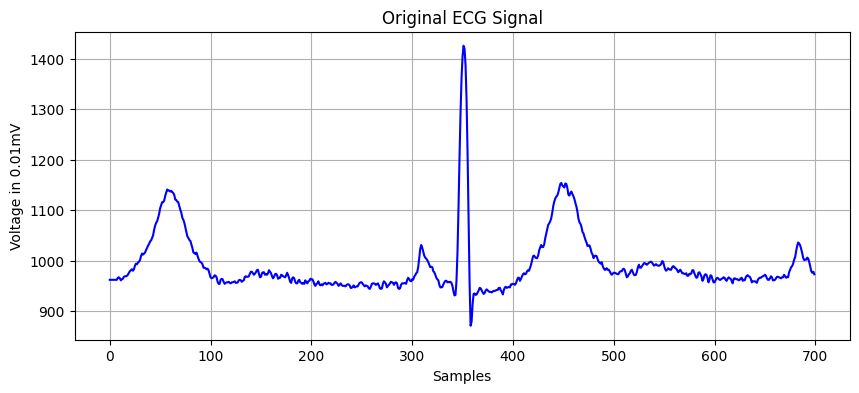

In [12]:
# Plot the original ECG signal
plt.figure(figsize=(10, 4))
plt.plot(temp_signal[:700], color='blue')
plt.title('Original ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Voltage in 0.01mV')
plt.grid()
plt.savefig('original_ecg_signal.png')
plt.show()

Class distribution

In [13]:
X=list()
y=list()
window_size=180
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1



    #signals = signals.reshape(-1,1)

    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data)):
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted)
            pos = int(next(splitted))
            arrhythmia_type = next(splitted)

            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

(100012, 360) (100012,)


In [14]:
count_classes

[75052, 8075, 7259, 2546, 7130]

In [15]:
# Overview of the dataset
print(f"Total records in dataset: {len(records)}")
print(f"Total classes: {n_classes}")
print("Class labels: ", classes)

Total records in dataset: 48
Total classes: 5
Class labels:  ['N', 'L', 'R', 'A', 'V']


0
0    75011
1     8071
2     7255
4     7129
3     2546
Name: count, dtype: int64


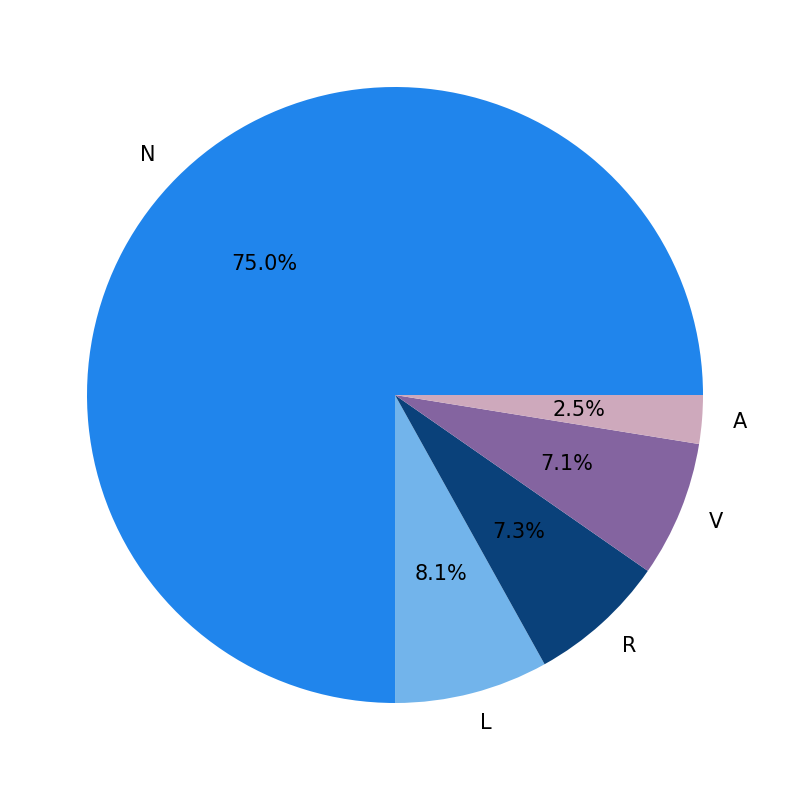

<Figure size 1000x600 with 0 Axes>

In [16]:
y_df = pd.DataFrame(y)
y_df.head()
per_class = y_df[y_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(30,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'V', 'A'], colors=['#2085ec','#72b4eb','#0a417a','#8464a0','#cea9bc'],autopct='%1.1f%%', textprops={'fontsize':15})

plt.show()
# The original code had p.savefig. p was not assigned. The line below uses plt.savefig instead
plt.savefig('Before_piechart') # Changed p to plt

In [17]:
X = np.array(X)
X_reshaped = X.reshape(-1,360,)
X_reshaped.shape

(100012, 360)

In [18]:
X_df = pd.DataFrame(X_reshaped)
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,957,956,961,964,964,966,965,966,967,969,...,955,957,958,958,955,955,955,960,958,957
1,950,951,952,951,956,959,961,960,958,958,...,950,948,950,952,951,952,951,948,950,951
2,946,949,952,956,957,958,957,957,959,960,...,956,957,957,958,957,956,957,960,956,956
3,960,961,960,959,961,965,967,964,965,967,...,957,956,958,960,961,959,957,953,955,956
4,939,940,943,948,950,951,951,951,955,958,...,960,962,962,962,958,957,958,960,959,959


In [19]:
X_new_df = pd.concat([X_df,y_df],axis=1)
X_new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,0
0,957,956,961,964,964,966,965,966,967,969,...,957,958,958,955,955,955,960,958,957,0
1,950,951,952,951,956,959,961,960,958,958,...,948,950,952,951,952,951,948,950,951,0
2,946,949,952,956,957,958,957,957,959,960,...,957,957,958,957,956,957,960,956,956,0
3,960,961,960,959,961,965,967,964,965,967,...,956,958,960,961,959,957,953,955,956,0
4,939,940,943,948,950,951,951,951,955,958,...,962,962,962,958,957,958,960,959,959,0


In [20]:
ax=list(range(361))
X_new_df = X_new_df.set_axis(ax, axis='columns')

In [21]:
df_0=(X_new_df[X_new_df[X_new_df.shape[1]-1]==0]).sample(n=20000,random_state=42)
df_1=X_new_df[X_new_df[X_new_df.shape[1]-1]==1]
df_2=X_new_df[X_new_df[X_new_df.shape[1]-1]==2]
df_3=X_new_df[X_new_df[X_new_df.shape[1]-1]==3]
df_4=X_new_df[X_new_df[X_new_df.shape[1]-1]==4]

df_1_upsample=resample(df_1,replace=True,n_samples=7000,random_state=125)
df_2_upsample=resample(df_2,replace=True,n_samples=7000,random_state=77)
df_3_upsample=resample(df_3,replace=True,n_samples=7000,random_state=103)
df_4_upsample=resample(df_4,replace=True,n_samples=7000,random_state=59)

X_new_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

360
0    20000
1     7000
2     7000
3     7000
4     7000
Name: count, dtype: int64


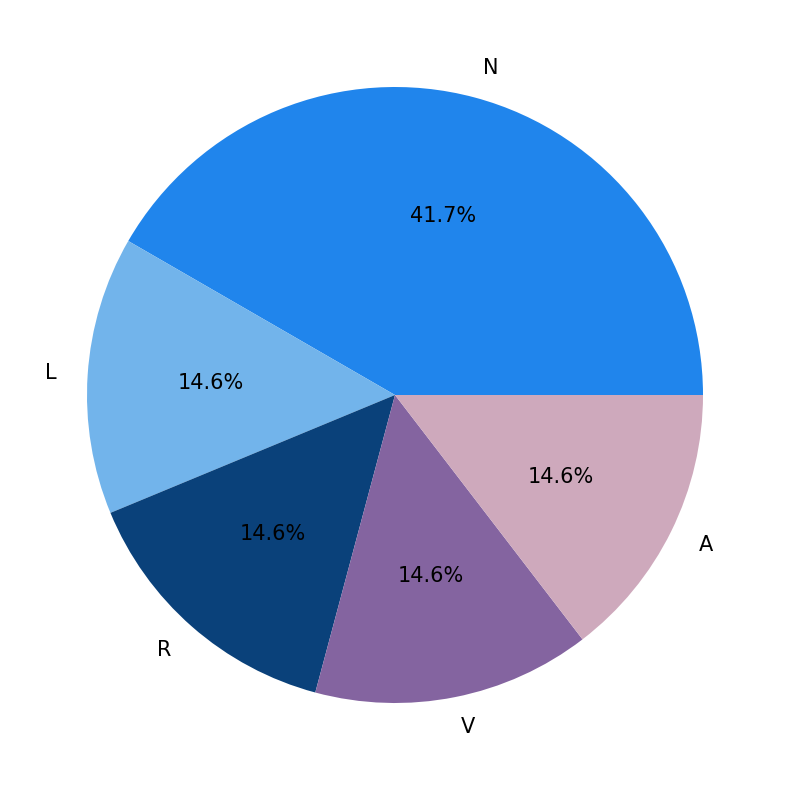

<Figure size 1000x600 with 0 Axes>

In [22]:
per_class = X_new_df[X_new_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(30,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'V', 'A'], colors=['#2085ec','#72b4eb','#0a417a','#8464a0','#cea9bc'],autopct='%1.1f%%',textprops={'fontsize':15})
plt.show()
plt.savefig('after_piechart')

<ipython-input-23-ca0c2fea8da6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=y_df, x=y_df[y_df.shape[1]-1].astype(str), palette='Set2')


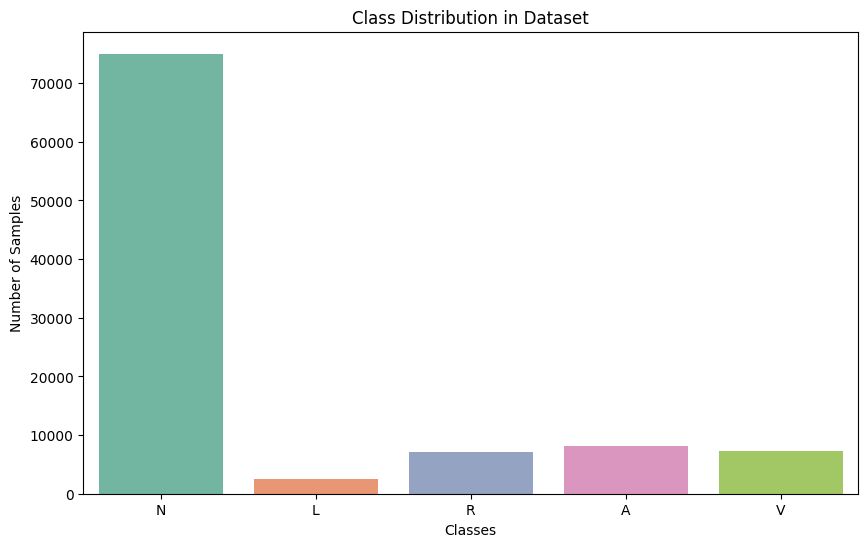

In [23]:
# Distribution of classes in the dataset
plt.figure(figsize=(10, 6))
sns.countplot(data=y_df, x=y_df[y_df.shape[1]-1].astype(str), palette='Set2')
plt.title('Class Distribution in Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(ticks=np.arange(len(classes)), labels=classes)
plt.savefig('class_distribution.png')
plt.show()

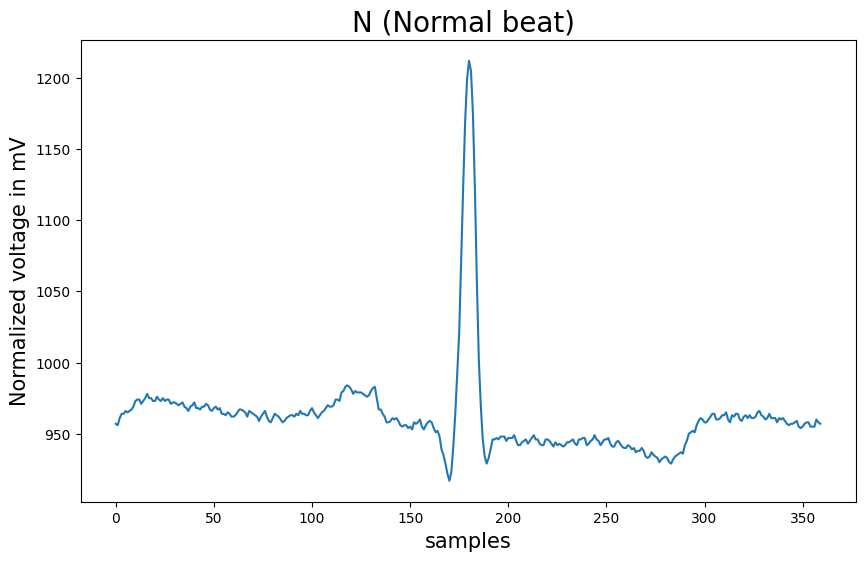

In [24]:
i=0;
while y[i]!=0:
    i=i+1

plt.plot(X[i])
plt.title('N (Normal beat) ', fontsize=20)
plt.xlabel('samples',fontsize=15);
plt.ylabel('Normalized voltage in mV',fontsize=15)
plt.savefig('N')

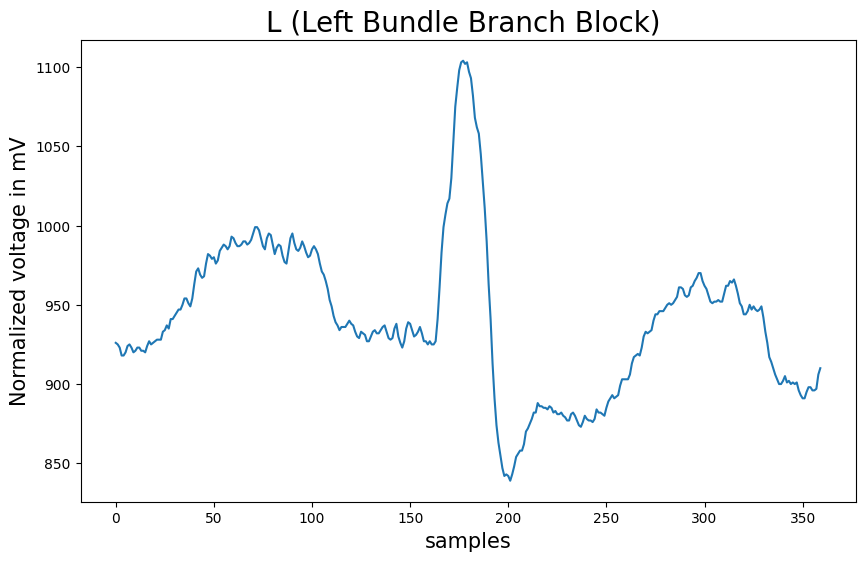

In [25]:
i=0;
while y[i]!=1:
    i=i+1

plt.plot(X[i])
plt.title('L (Left Bundle Branch Block) ', fontsize=20)
plt.xlabel('samples',fontsize=15);
plt.ylabel('Normalized voltage in mV',fontsize=15)
plt.savefig('L')

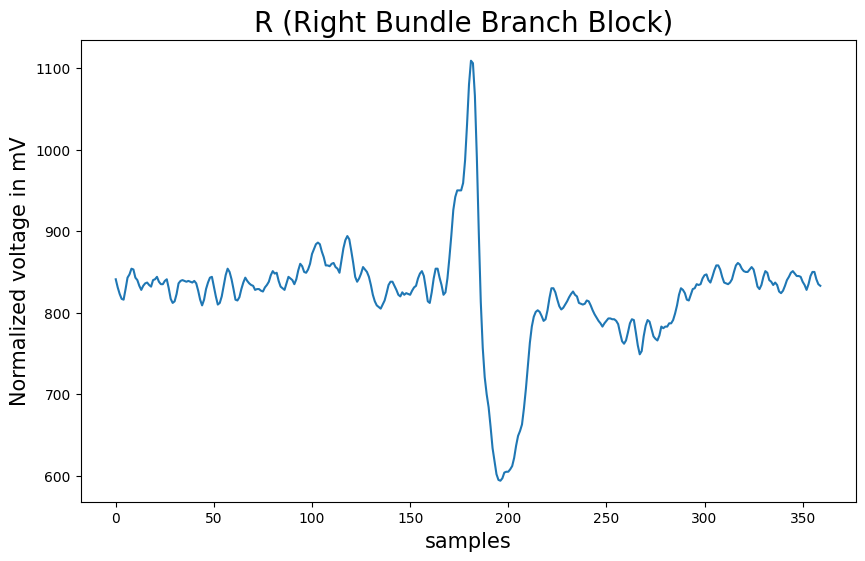

In [26]:
i=0;
while y[i]!=2:
    i=i+1

plt.plot(X[i])
plt.title('R (Right Bundle Branch Block) ', fontsize=20)
plt.xlabel('samples',fontsize=15);
plt.ylabel('Normalized voltage in mV',fontsize=15)
plt.savefig('R')

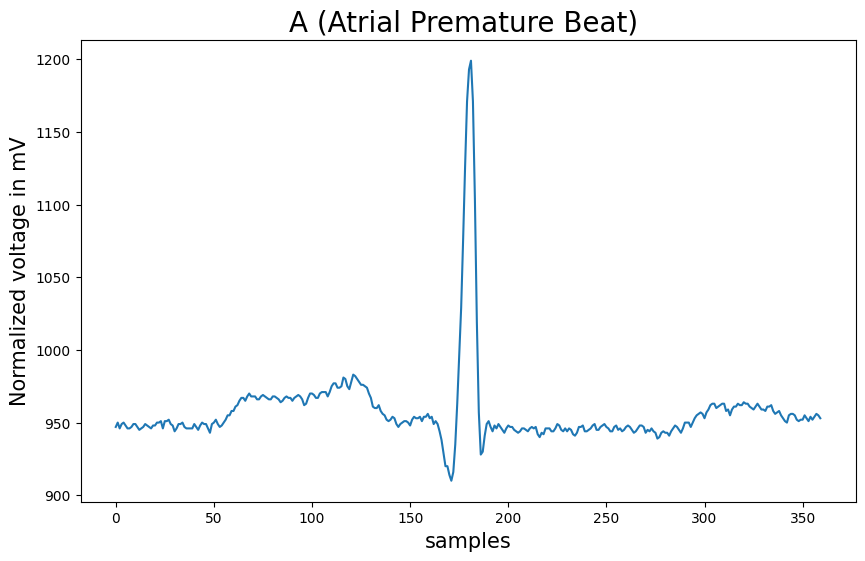

In [27]:
i=0;
while y[i]!=3:
    i=i+1

plt.plot(X[i])
plt.title('A (Atrial Premature Beat) ', fontsize=20)
plt.xlabel('samples',fontsize=15);
plt.ylabel('Normalized voltage in mV',fontsize=15)
plt.savefig('A')

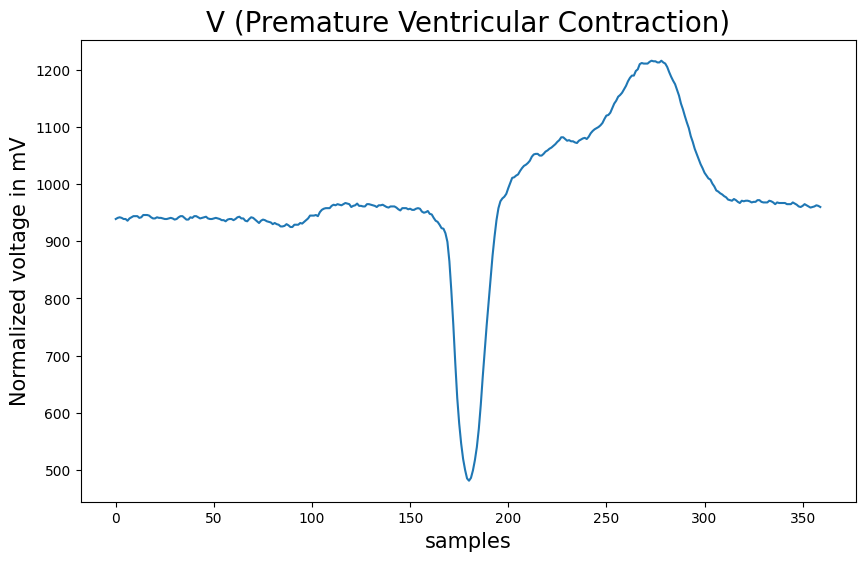

In [28]:
i=0;
while y[i]!=4:
    i=i+1

plt.plot(X[i])
plt.title('V (Premature Ventricular Contraction)', fontsize=20)
plt.xlabel('samples',fontsize=15);
plt.ylabel('Normalized voltage in mV',fontsize=15)
plt.savefig('V')

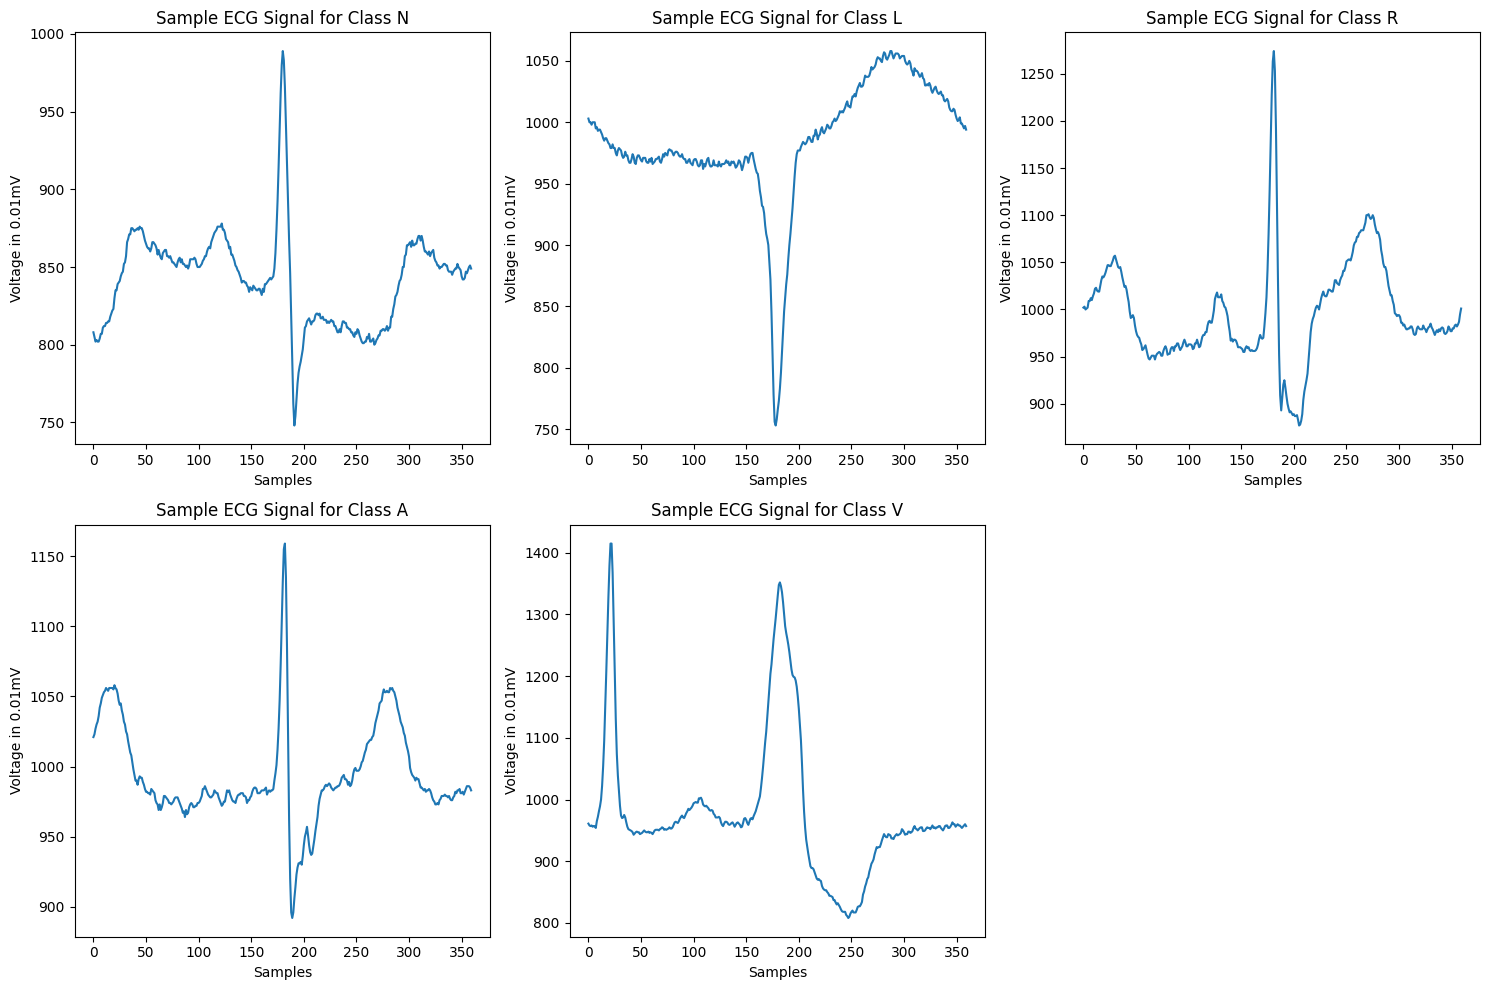

In [29]:
# Plot sample ECG signals from each class
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes):
    plt.subplot(2, 3, i + 1)
    samples = X_new_df[X_new_df[X_new_df.shape[1]-1] == i].sample(n=1)  # Get one random sample from each class
    plt.plot(samples.iloc[:, :-1].values.T)
    plt.title(f'Sample ECG Signal for Class {class_name}')
    plt.xlabel('Samples')
    plt.ylabel('Voltage in 0.01mV')
plt.tight_layout()
plt.savefig('sample_ecg_signals.png')
plt.show()


In [30]:
train, test = train_test_split(X_new_df, test_size=0.20, random_state=7)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (38400, 361)
X_test  :  (9600, 361)


In [31]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
print(np.shape(y_train), np.shape(y_test))

(38400, 5) (9600, 5)


In [32]:
X_train = train.iloc[:,:train.shape[1]-1].values
X_test = test.iloc[:,:test.shape[1]-1].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
print(np.shape(X_train), np.shape(X_test))

(38400, 360, 1) (9600, 360, 1)


<ipython-input-33-e7415fe57a08>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_df[y_df.shape[1]-1], palette='viridis')
<ipython-input-33-e7415fe57a08>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=per_class_after.index, y=per_class_after.values, palette='viridis')


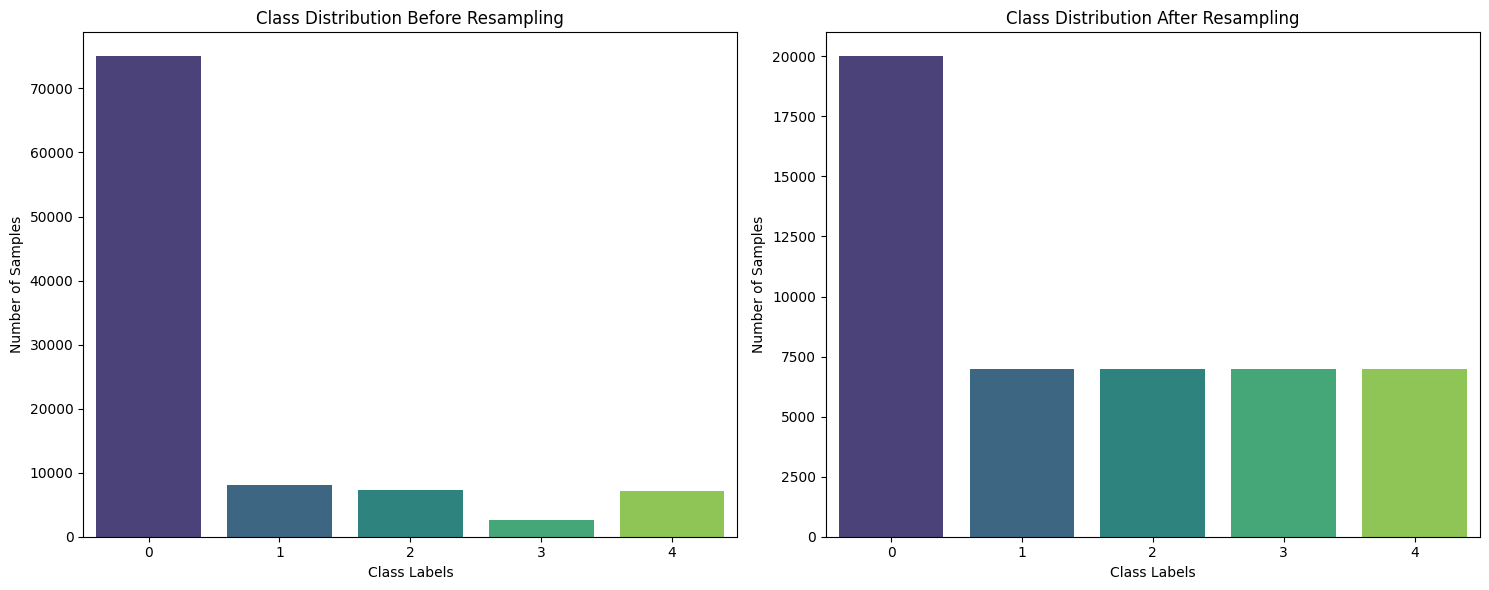

In [33]:
# Class distribution before resampling
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=y_df[y_df.shape[1]-1], palette='viridis')
plt.title('Class Distribution Before Resampling')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')

# Class distribution after resampling
plt.subplot(1, 2, 2)
per_class_after = X_new_df[X_new_df.shape[1]-1].value_counts()
sns.barplot(x=per_class_after.index, y=per_class_after.values, palette='viridis')
plt.title('Class Distribution After Resampling')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')

plt.tight_layout()
plt.savefig('class_imbalance_analysis.png')
plt.show()

model

In [34]:
#cnn-bilstm

from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

# Input shape
input_shape = (360, 1)  # Adjust according to your data

# Define the CNN-BiLSTM model
def create_cnn_bilstm_model(input_shape):
    # ECG Input
    ecg_input = Input(shape=input_shape, name='ecg_input')

    # CNN Layers
    x = Conv1D(filters=32, kernel_size=5, activation='relu')(ecg_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.5)(x)

    x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.5)(x)

    # Flatten the output before feeding into LSTM
    x = Flatten()(x)

    # Reshape for LSTM using Keras Reshape layer
    x = Reshape((1, -1))(x)  # Reshape to (batch_size, 1, features)

    # BiLSTM Layer
    x = Bidirectional(LSTM(100, return_sequences=True))(x)
    x = Bidirectional(LSTM(100))(x)

    # Dense Layer with Softmax for classification
    output = Dense(5, activation='softmax')(x)

    # Model Definition
    model = Model(inputs=ecg_input, outputs=output)

    # Model Compilation
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [35]:
# Create and summarize the model
model = create_cnn_bilstm_model(input_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ ecg_input (InputLayer)               │ (None, 360, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 356, 32)             │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 178, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 178, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 174, 64)             │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 87, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 87, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 5568)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1, 200)              │       4,535,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           1,005 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,787,501 (18.26 MB)

 Trainable params: 4,787,501 (18.26 MB)

 Non-trainable params: 0 (0.00 B)

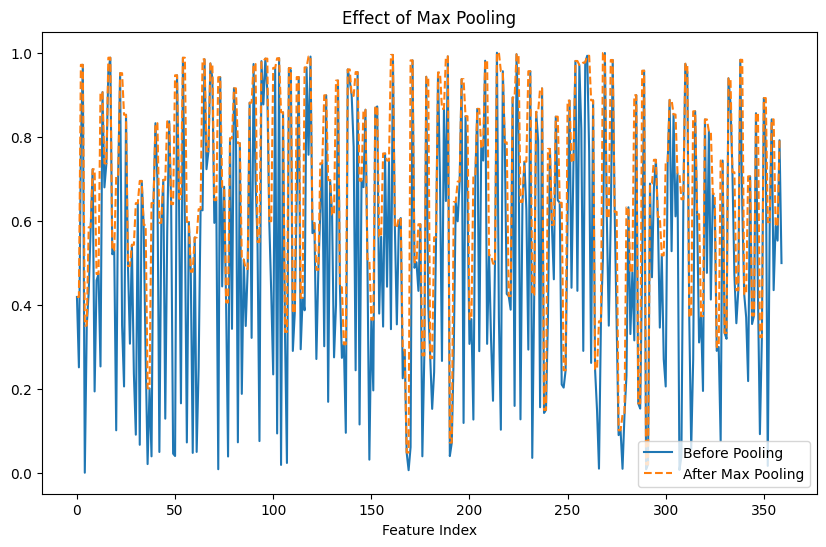

In [36]:
from tensorflow.keras.layers import MaxPooling1D

# Example array to demonstrate max pooling
sample_array = np.random.rand(1, 360, 1)  # Single "image" for demo
max_pool = MaxPooling1D(pool_size=2)
pooled_output = max_pool(sample_array)

# Plotting comparison
plt.plot(sample_array[0], label="Before Pooling")
plt.plot(np.repeat(pooled_output[0], 2), label="After Max Pooling", linestyle='--')
plt.legend()
plt.title("Effect of Max Pooling")
plt.xlabel("Feature Index")
plt.show()

In [37]:
# Flatten the example data
flattened_output = pooled_output.numpy().flatten()

# Reshape for LSTM
reshaped_for_lstm = flattened_output.reshape(1, -1)  # Reshape to (1, features) for LSTM
print("Shape before flatten:", pooled_output.shape)
print("Shape after flatten:", flattened_output.shape)
print("Shape after reshape:", reshaped_for_lstm.shape)

Shape before flatten: (1, 180, 1)
Shape after flatten: (180,)
Shape after reshape: (1, 180)


In [38]:
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Sequential

# Sample data
sample_input = np.random.rand(1, 180, 1)  # Random example data

# BiLSTM Model
model_bilstm = Sequential([
    Bidirectional(LSTM(100, return_sequences=True), input_shape=(180, 1)),
])

# Predict using BiLSTM
bilstm_output = model_bilstm(sample_input)
print("Output shape of BiLSTM:", bilstm_output.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Output shape of BiLSTM: (1, 180, 200)


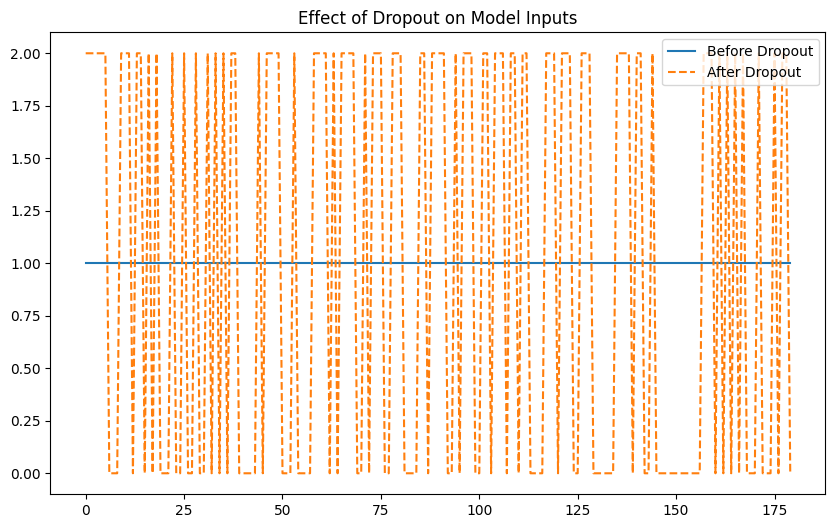

In [39]:
from tensorflow.keras.layers import Dropout

# Example array before dropout
sample_data = np.ones((1, 180, 1))

# Applying dropout
dropout_layer = Dropout(0.5)
output_after_dropout = dropout_layer(sample_data, training=True)

# Plotting the effect
plt.plot(sample_data[0], label="Before Dropout")
plt.plot(output_after_dropout[0], label="After Dropout", linestyle='--')
plt.legend()
plt.title("Effect of Dropout on Model Inputs")
plt.show()

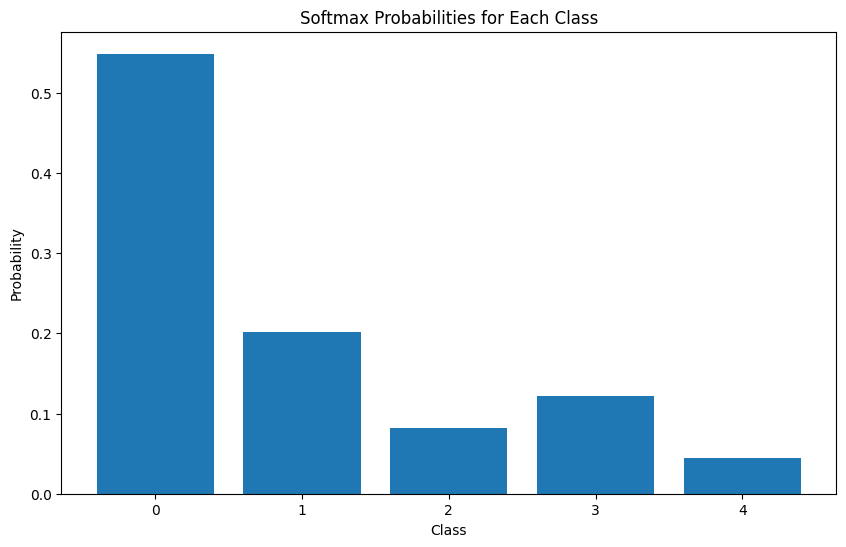

In [40]:
from tensorflow.keras.activations import softmax

# Sample logits for classes
logits = np.array([2.0, 1.0, 0.1, 0.5, -0.5])

# Softmax activation
softmax_probs = softmax(logits).numpy()
plt.bar(range(len(softmax_probs)), softmax_probs)
plt.title("Softmax Probabilities for Each Class")
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


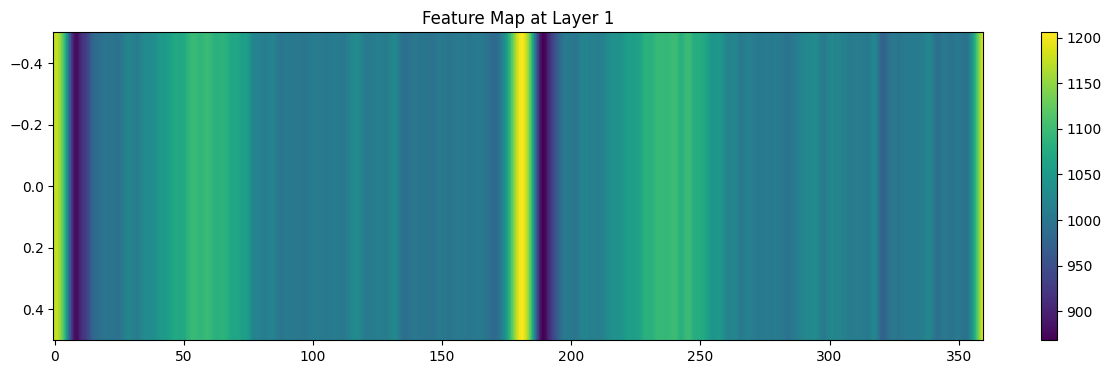

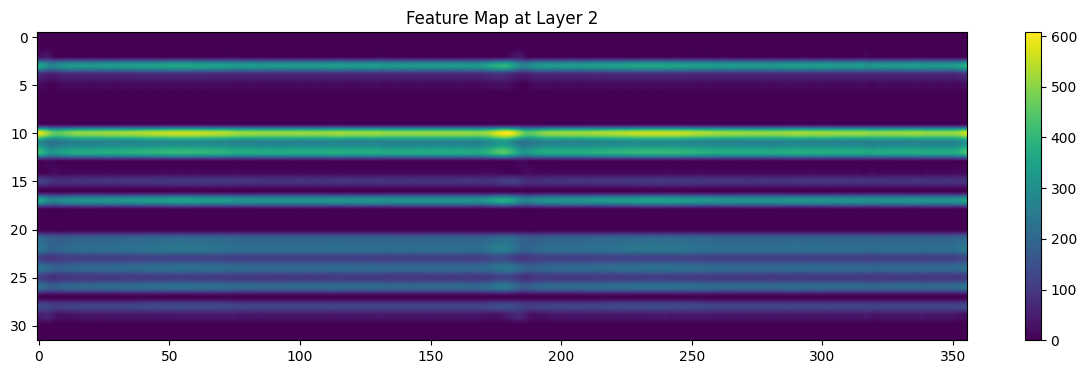

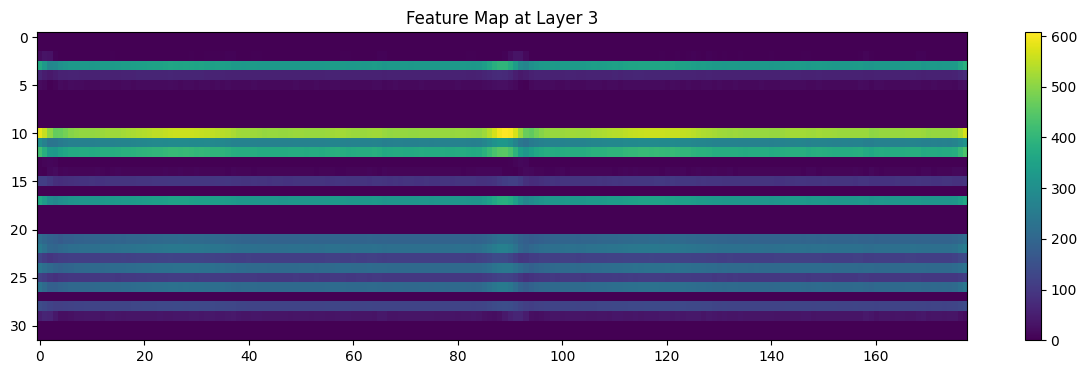

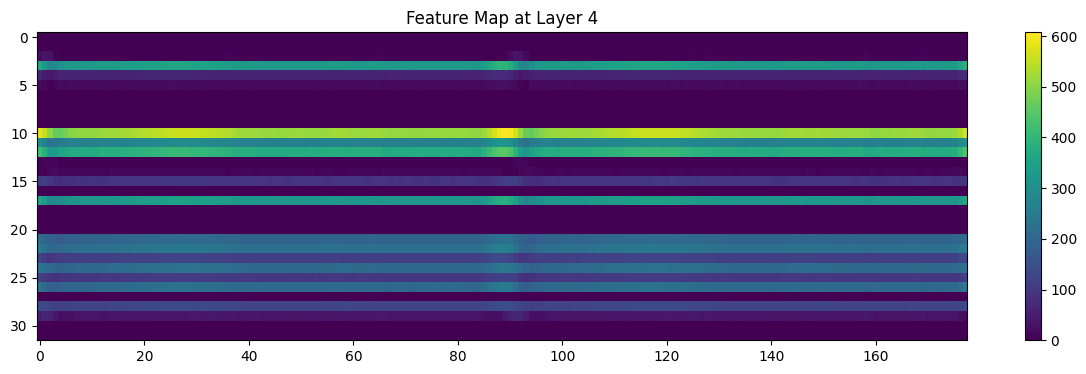

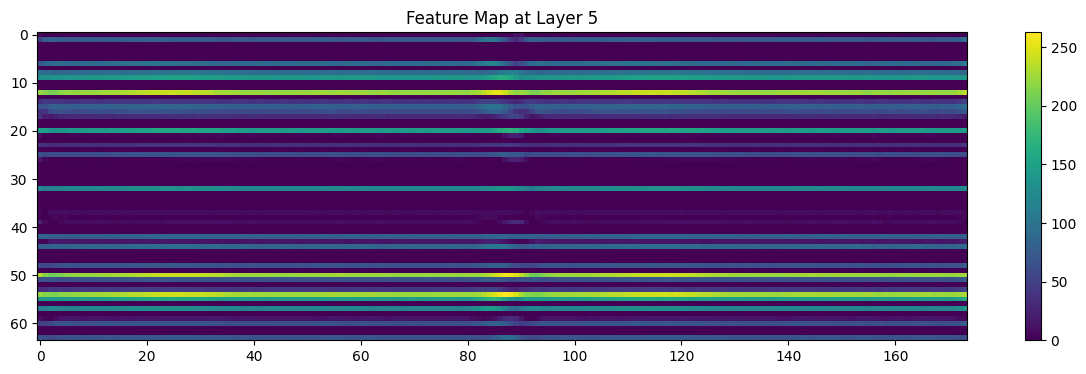

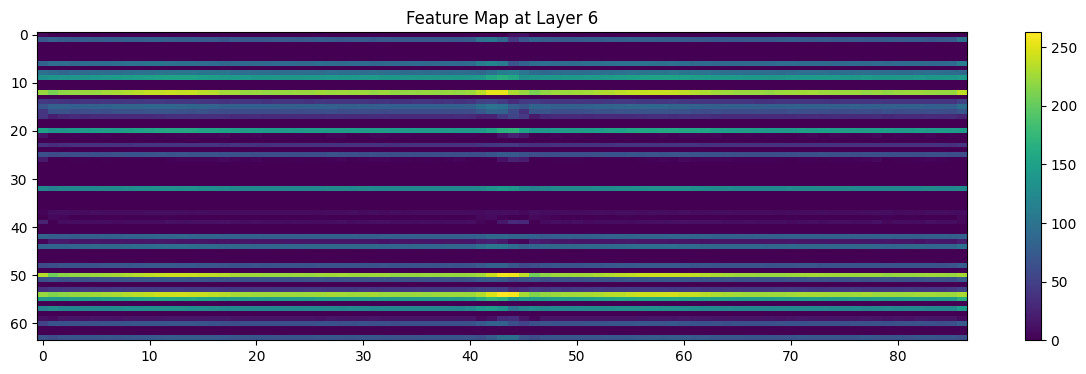

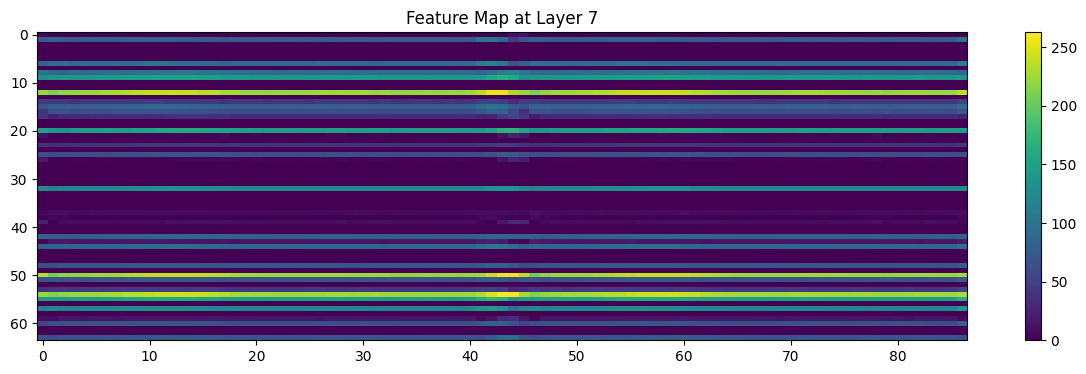

In [41]:
from tensorflow.keras import Model

# Get intermediate layers
layer_outputs = [layer.output for layer in model.layers[:7]]
feature_extractor = Model(inputs=model.input, outputs=layer_outputs)

# Extract features
features = feature_extractor.predict(X_train[:1])  # Assuming X_train is already defined
for idx, feature_map in enumerate(features):
    plt.figure(figsize=(15, 4))
    plt.title(f"Feature Map at Layer {idx + 1}")
    plt.imshow(feature_map[0, :, :].T, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.show()


In [42]:
# Model Training (replace X_train, y_train with your actual training data)
history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_split=0.2)

# Model Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

Epoch 1/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 74s 140ms/step - accuracy: 0.4123 - loss: 1.4970 - val_accuracy: 0.4168 - val_loss: 1.4891
Epoch 2/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 68s 142ms/step - accuracy: 0.4203 - loss: 1.4864 - val_accuracy: 0.4168 - val_loss: 1.4890
Epoch 3/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 65s 136ms/step - accuracy: 0.4215 - loss: 1.4841 - val_accuracy: 0.4168 - val_loss: 1.4902
Epoch 4/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 65s 135ms/step - accuracy: 0.4165 - loss: 1.4895 - val_accuracy: 0.4168 - val_loss: 1.4891
Epoch 5/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 66s 138ms/step - accuracy: 0.4198 - loss: 1.4856 - val_accuracy: 0.4168 - val_loss: 1.4881
Epoch 6/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 81s 135ms/step - accuracy: 0.4187 - loss: 1.4867 - val_accuracy: 0.4168 - val_loss: 1.4878
Epoch 7/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 84s 140ms/step - accuracy: 0.4185 - loss: 1.4866 - val_accuracy: 0.4168 - val_loss: 1.4880
Epoch 8/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 79s 135ms/step - accuracy: 0.4155 - loss: 1

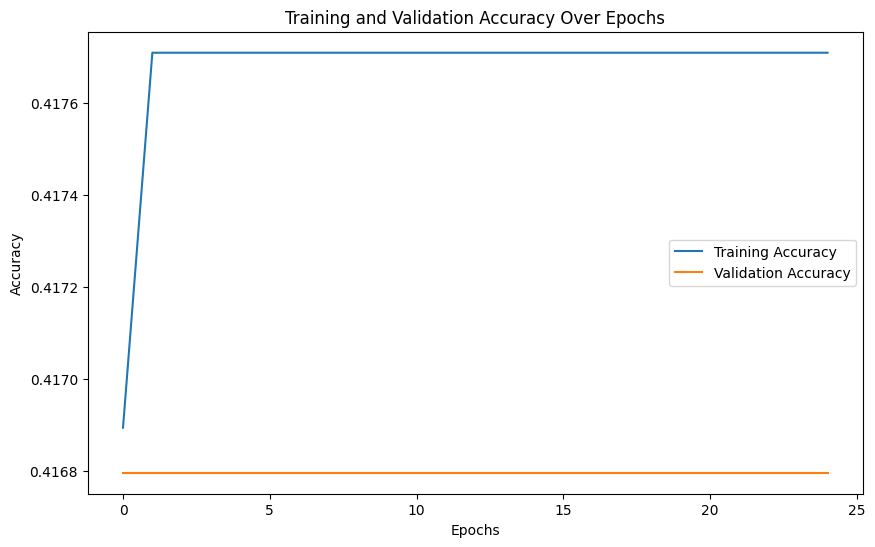

In [43]:
# Plot accuracy and loss over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()
plt.show()

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Generate synthetic ECG signal for demonstration
time = np.linspace(0, 1, 500)
signal = np.sin(2 * np.pi * 5 * time) + 0.5 * np.random.normal(size=time.shape)




300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


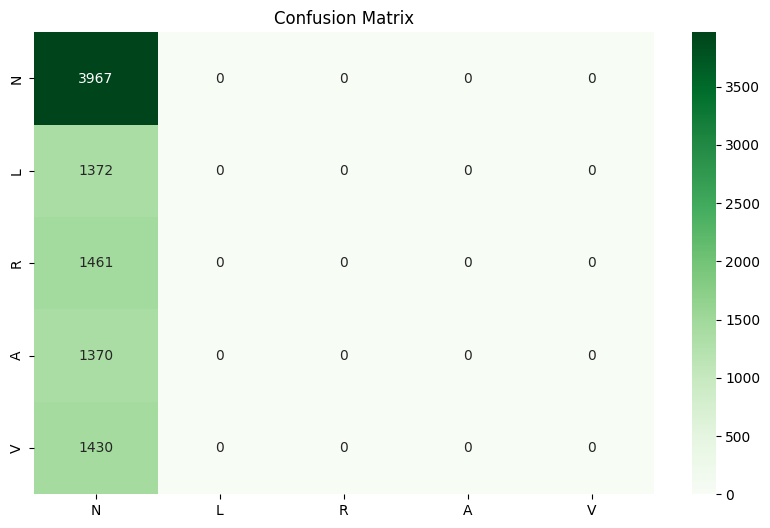

In [48]:
# True labels
y_true = []
for element in y_test:
    y_true.append(np.argmax(element))

# Model Prediction
prediction_proba = model.predict(X_test)
prediction = np.argmax(prediction_proba, axis=1)

# Confusion Matrix
ax = plt.subplot()
custCnnConfMat = confusion_matrix(y_true, prediction)

# Plotting Confusion Matrix
sns.heatmap(custCnnConfMat, annot=True, fmt='d', cmap='Greens', ax=ax)
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(classes)  # Define 'classes' according to your class labels
ax.yaxis.set_ticklabels(classes)  # Define 'classes' according to your class labels
plt.savefig('cm.png')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


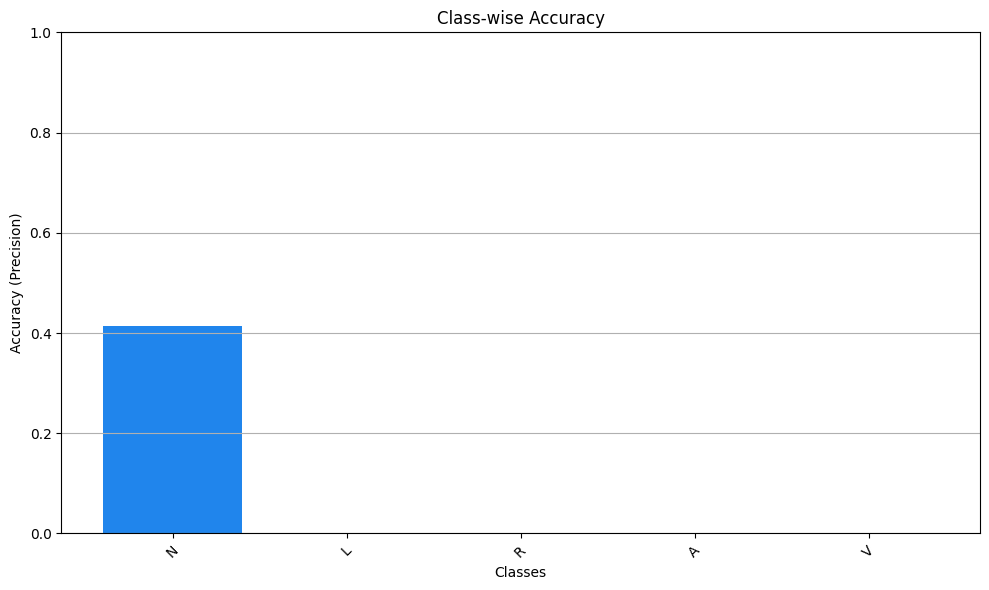

Class: N - Precision: 0.41, Recall: 1.00, F1-score: 0.58
Class: L - Precision: 0.00, Recall: 0.00, F1-score: 0.00
Class: R - Precision: 0.00, Recall: 0.00, F1-score: 0.00
Class: A - Precision: 0.00, Recall: 0.00, F1-score: 0.00
Class: V - Precision: 0.00, Recall: 0.00, F1-score: 0.00


In [49]:
# Calculate precision, recall, and F1 score for each class
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, prediction, target_names=classes, output_dict=True)

# Extracting metrics for each class
class_metrics = {class_name: report[class_name] for class_name in classes}

# Prepare data for plotting
class_names = list(class_metrics.keys())
accuracies = [class_metrics[class_name]['precision'] for class_name in class_names]

# Create a bar plot for class-wise accuracy
plt.figure(figsize=(10, 6))
plt.bar(class_names, accuracies, color=['#2085ec', '#72b4eb', '#0a417a', '#8464a0', '#cea9bc'])
plt.title('Class-wise Accuracy')
plt.xlabel('Classes')
plt.ylabel('Accuracy (Precision)')
plt.ylim(0, 1)  # Set y-axis limits to 0 and 1
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('class_wise_accuracy.png')  # Save the plot as a PNG file
plt.show()

# Print the class-wise metrics for reference
for class_name, metrics in class_metrics.items():
    print(f"Class: {class_name} - Precision: {metrics['precision']:.2f}, Recall: {metrics['recall']:.2f}, F1-score: {metrics['f1-score']:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score      support
N              0.413229  1.000000  0.584801  3967.000000
L              0.000000  0.000000  0.000000  1372.000000
R              0.000000  0.000000  0.000000  1461.000000
A              0.000000  0.000000  0.000000  1370.000000
V              0.000000  0.000000  0.000000  1430.000000
accuracy       0.413229  0.413229  0.413229     0.413229
macro avg      0.082646  0.200000  0.116960  9600.000000
weighted avg   0.170758  0.413229  0.241657  9600.000000


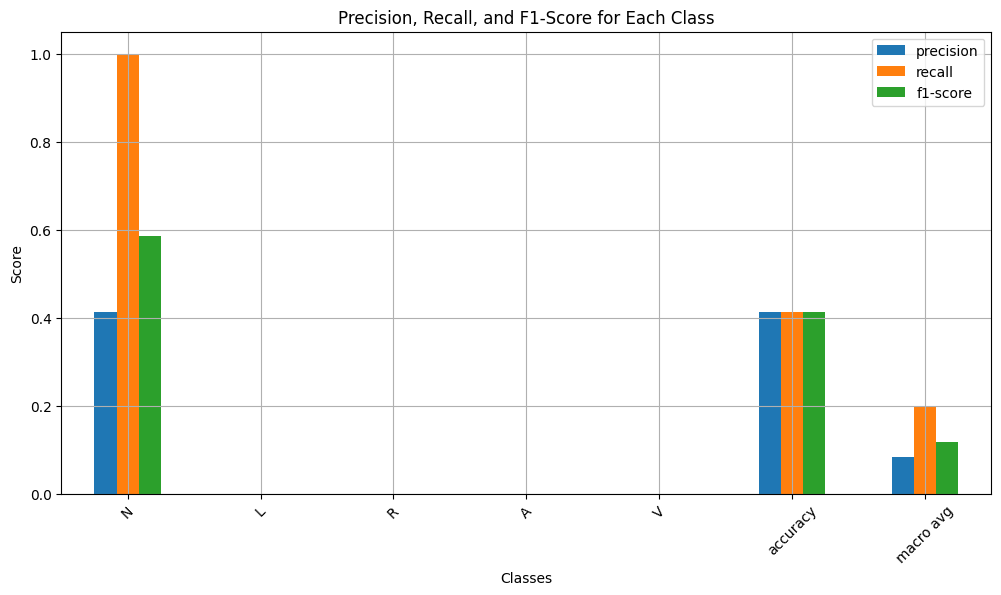

In [50]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, prediction, target_names=classes, output_dict=True)

# Convert report to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()
print(report_df)

# Plotting Precision, Recall, and F1-Score
report_df[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(12, 6))
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.ylabel('Score')
plt.xlabel('Classes')
plt.xticks(rotation=45)
plt.grid()
plt.savefig('precision_recall_f1.png')
plt.show()

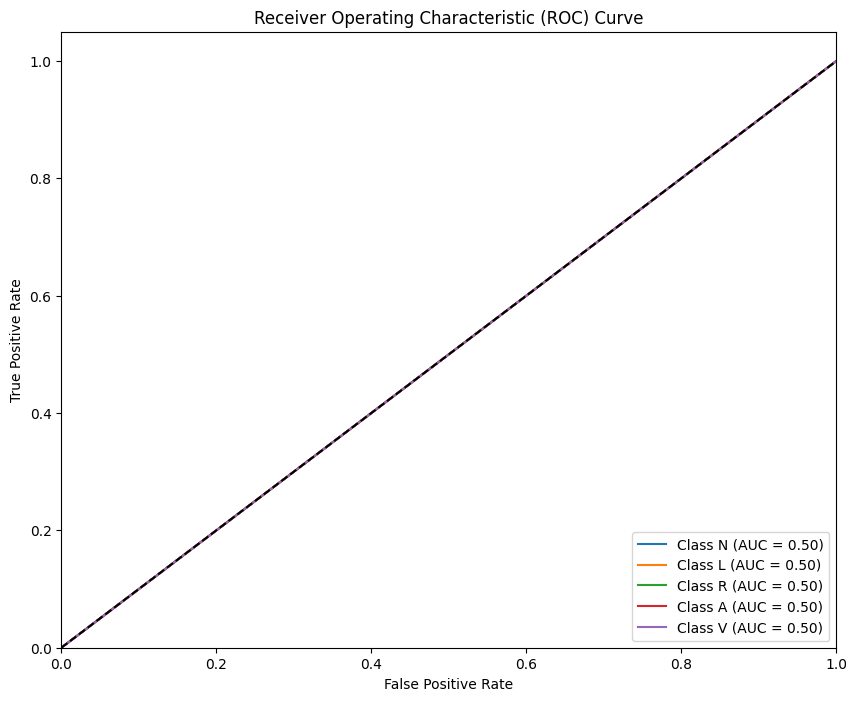

In [51]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output
y_test_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], prediction_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()


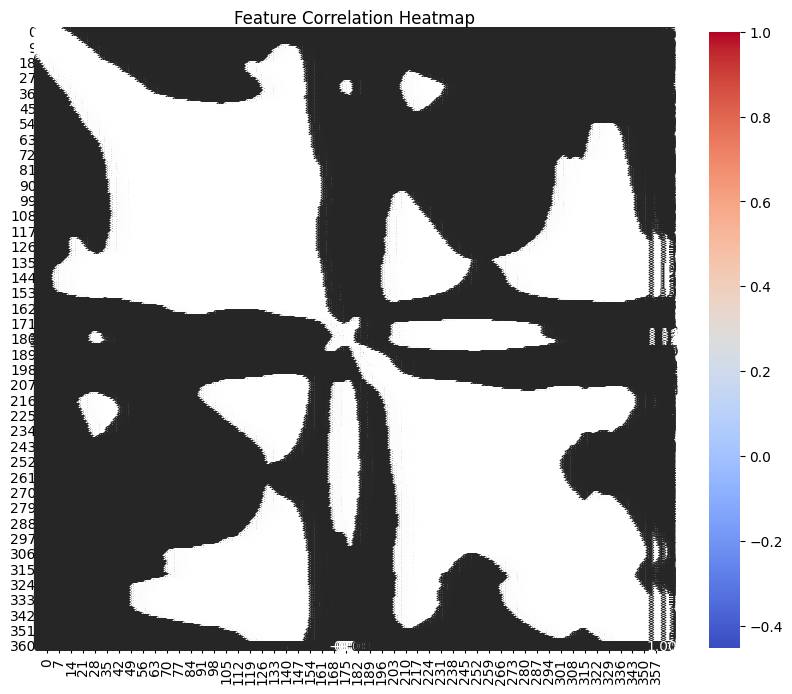

In [52]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = X_new_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Feature Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
plt.show()